# Prediction code for Utah FORGE data

In [13]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import optimizers, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import *
from keras.models import load_model
from keras.utils import Sequence
import tensorflow.keras.backend as K
from numpy.random import seed

from utils import *
from model import *

# Define paths for figures and models
fig_path = "./figs/FORGE/"
model_path = "./model/"

# Create directories if they do not exist
os.makedirs(fig_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

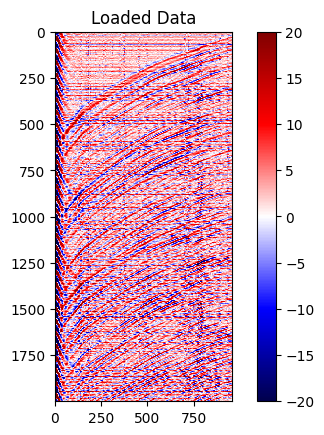

In [14]:
# Paths and parameters
data_path = './data/'
eq_num = 36
data_name = f'eq-{eq_num}'

# Patch parameters
w1, w2 = 24, 24
z1, z2 = 6, 6
batch_size = 1024
drop_rate = 0.2
epochs = 50

# Load and visualize data
data = np.load(f'{data_path}{data_name}.npy')

plt.imshow(data.T, cmap='seismic', vmin=-20, vmax=20)
plt.title('Loaded Data')
plt.colorbar()
plt.show()

# Apply patching
data_noisy = yc_patch(data, w1, w2, z1, z2)

In [15]:
## load trained model
model = load_model(f'{model_path}FORGE_model_{data_name}_p{w1}_s{z1}_drop_{drop_rate}_ep{epochs}.h5')

## prediction
out = model.predict(data_noisy)
out = np.transpose(out)


# unpatching
[n1, n2] = data.shape
predicted = yc_patch_inv(out,n1,n2,w1,w2,z1,z2)

1624/1624 [==============================] - 9s 6ms/step


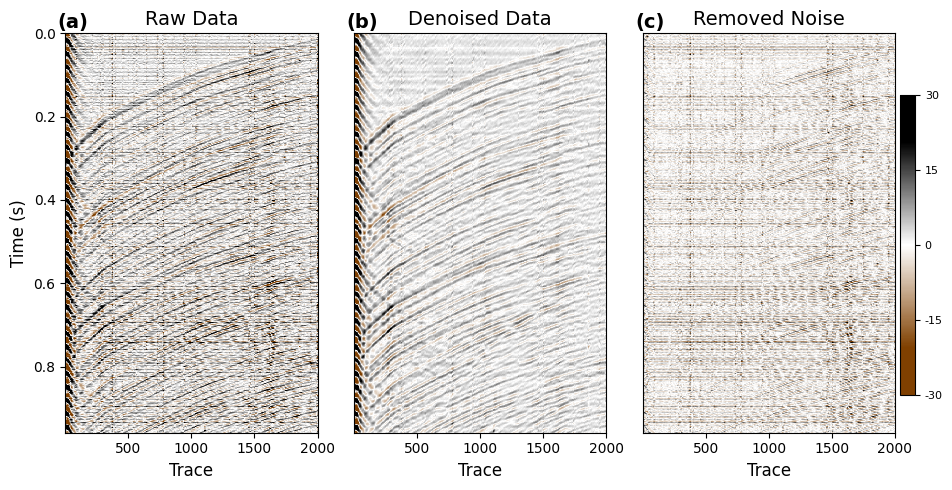

In [16]:
# Constants
v = 30  # Color scale limit
xx, yy = 100, 0.04
v1 = 1

# Data dimensions and time axis
num_samples = data.shape[0]
num_samples_x = data.shape[1]
time_interval = 0.001
time = np.arange(0, num_samples) * time_interval

# Annotation positions
mm = -0.03
nn = 1.05

# Create the figure and subplots
fig = plt.figure(figsize=(10, 5))

# Plot 1: Raw data
ax1 = fig.add_subplot(1, 3, 1)
im1 = ax1.imshow(
    data.T, cmap=cseis(), vmin=-v, vmax=v, aspect='auto', extent=(1, num_samples_x, time[-1], 0)
)
ax1.set_xlabel("Trace", fontsize=12)
ax1.set_ylabel("Time (s)", fontsize=12)
ax1.set_title('Raw Data', fontsize=14)
ax1.annotate('(a)', xy=(mm, nn), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top')

# Plot 2: Denoised data
ax2 = fig.add_subplot(1, 3, 2)
im2 = ax2.imshow(
    predicted.T, cmap=cseis(), vmin=-v, vmax=v, aspect='auto', extent=(1, num_samples_x, time[-1], 0)
)
ax2.set_xlabel("Trace", fontsize=12)
ax2.set_yticks([])  # Remove y-ticks for cleaner appearance
ax2.set_title('Denoised Data', fontsize=14)
ax2.annotate('(b)', xy=(mm, nn), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top')

# Plot 3: Removed noise
ax3 = fig.add_subplot(1, 3, 3)
im3 = ax3.imshow(
    (data - predicted).T, cmap=cseis(), vmin=-v, vmax=v, aspect='auto', extent=(1, num_samples_x, time[-1], 0)
)
ax3.set_xlabel("Trace", fontsize=12)
ax3.set_yticks([])  # Remove y-ticks for cleaner appearance
ax3.set_title('Removed Noise', fontsize=14)
ax3.annotate('(c)', xy=(mm, nn), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top')

# Adjust layout and add colorbar
plt.tight_layout()
fig.subplots_adjust(right=0.9)  # Make space for colorbar

# Add colorbar
cbar_ax = fig.add_axes([0.905, 0.2, 0.015, 0.6])  # [left, bottom, width, height]
cb = plt.colorbar(im3, cax=cbar_ax)
cb.ax.tick_params(labelsize=8)
cbar_ticks = np.linspace(-v, v, 5)  # 5 ticks evenly spaced
cb.set_ticks(cbar_ticks)
cb.set_ticklabels([f'{tick:.0f}' for tick in cbar_ticks])

# Save and show the plot
output_file = f'{fig_path}{data_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epochs}.png'
plt.savefig(output_file, dpi=200)
plt.show()

### 